# Emergence of Low-level Mathematical Operations in MLPs - Single Task Networks

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import os
import random
from collections import OrderedDict

## Global utilities

### Misc

In [2]:
def generate_seed():
    return np.random.randint(1, 2**32 - 1)


def set_all_seeds(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

### Network

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, use_act=True, dim=32, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(2, dim, use_act=use_act),
            LinearLayer(dim, 1, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)


def print_model_parameters(model):
    for name, param in model.named_parameters():
        print(name, "\n", param.data, "\n")

### Data

In [4]:
def generate_data():
    eps = 0.5

    Y = torch.rand(10000)
    X = torch.empty(10000, 2)
    X[:, 0] = Y / (torch.rand(10000) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # need to randomly swap x1 and x2 so that they're identically distributed - can do this because their product is commutative
    mask = torch.rand(10000) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    assert torch.allclose(X[:, 0] * X[:, 1], Y)

    Y = Y[:, None]

    # Train/valid split

    s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

    X_train = X[s_inds[:8000]]
    Y_train = Y[s_inds[:8000]]
    X_valid = X[s_inds[8000:]]
    Y_valid = Y[s_inds[8000:]]

    return X_train, Y_train, X_valid, Y_valid


def plot_data_distribution(X, Y):
    _, ax = plt.subplots()

    ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
    ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
    ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
    ax.legend()

### Training/evaluation

In [55]:
def train(model, data, lr=1e-2):
    N = 4000  # number of epochs

    X_train, Y_train, X_valid, Y_valid = data

    loss_func = nn.MSELoss()
    optimiser = Adam(model.parameters(), lr=lr)
    log = []

    for i in tqdm(range(N)):
        log_sample = {}

        # Training update
        model.train()
        model.zero_grad()
        Y_hat = model(X_train)
        loss = loss_func(Y_hat, Y_train)
        log_sample["train_loss"] = float(loss.detach())
        loss.backward()
        optimiser.step()

        # Validation set
        model.eval()
        Y_hat = model(X_valid)
        loss = loss_func(Y_hat, Y_valid)
        log_sample["valid_loss"] = float(loss.detach())

        log.append(log_sample)

    df = pd.DataFrame(log)

    return model, df


def plot_loss(train_loss, valid_loss, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    ax.plot(train_loss, label="train")
    ax.plot(valid_loss, label="valid")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()


def get_preds(model, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.flatten().numpy()
    y_targs = Y_valid.flatten().numpy()

    return y_preds, y_targs


def get_valid_loss(model, loss_func, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    return loss_func(out, Y_valid)


def plot_results(y_preds, y_targs, ax=None, title=None):
    if ax is None:
        _, ax = plt.subplots()

    ax.scatter(y_preds, y_targs, s=4, label="predictions")
    ax.plot(y_targs, y_targs, color="salmon", ls="--", lw=0.5, label="perfect accuracy")
    ax.set(xlabel="y_preds", ylabel="y_targs")
    ax.legend()
    ax.set_aspect("equal")
    if title is not None:
        ax.set_title(title)


def plot_model_performance_summary(model, df, X_valid, Y_valid):
    _, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0] = plot_loss(df["train_loss"], df["valid_loss"], ax=axes[0])

    y_preds, y_targs = get_preds(model, X_valid, Y_valid)
    plot_results(y_preds, y_targs, ax=axes[1])
    axes[1].set_title(f"Validation loss: {get_valid_loss(model, nn.MSELoss(), X_valid, Y_valid):.5f}")

### Analysis functions

In [106]:
import warnings
from math import ceil

warnings.filterwarnings(
    "ignore", "This figure includes Axes that are not compatible with tight_layout, so results might be incorrect."
)


def capture_intermediate_outputs(model, input_tensor):
    """
    Captures the intermediate outputs of a PyTorch model.

    Args:
        model: A PyTorch model.
        input_tensor: A PyTorch tensor of shape (batch_size, *).
    Returns:
        A dictionary mapping layer names to intermediate outputs.
    """
    intermediate_values = OrderedDict()

    def hook_fn(module, input, output, name):
        if isinstance(module, nn.Linear):
            weight = module.weight
            input_value = input[0]
            intermediate_output = input_value.matmul(weight.t())
            intermediate_values[f"{name}.weight"] = intermediate_output
            intermediate_values[f"{name}.bias"] = output
        else:
            intermediate_values[name] = output

    hooks = []
    for name, layer in model.named_modules():
        hook = layer.register_forward_hook(
            lambda module, input, output, name=name: hook_fn(module, input, output, name)
        )
        hooks.append(hook)

    with torch.inference_mode():
        _ = model(input_tensor)

    for hook in hooks:
        hook.remove()

    filtered_values = {k: t for k, t in intermediate_values.items() if len(k.split(".")) > 2}
    return filtered_values


def plot_neuron_contributions(model, N=5):
    """Plots the contribution of each neuron to the final output.

    NOTE: this ignores the effect of the bias
    """

    eps = 0.05
    pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T)

    outputs = capture_intermediate_outputs(model, torch.as_tensor(pairs).float())
    lws = model.state_dict()["layers.1.linear.weight"]
    acts = outputs["layers.0.act"]
    acts = acts * lws[0, :]  # linear weighting now (I know they're not technically activations anymore)

    fig = plt.figure(figsize=(12, 10))  # Increase the width to make space for the colorbar

    for i in range(acts.shape[1]):
        ax = fig.add_subplot(4, 4, i + 1)
        col = acts[:, i]
        activated_mask = acts[:, i].abs() > eps  # really trying to focus on the activated areas
        activated_mask = torch.ones(col.shape, dtype=bool)
        sc = ax.scatter(
            pairs[activated_mask, 0],
            pairs[activated_mask, 1],
            c=col[activated_mask],
            cmap="bwr",
            s=50,
            norm=plt.Normalize(vmin=-1, vmax=1),
        )

        ax.set_title(f"Neuron {i+1}")
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_aspect("equal")
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)

    # Position the colorbar on the right of the last subplot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(sc, cax=cbar_ax)

    bias = float(model.state_dict()["layers.1.linear.bias"][0])

    fig.suptitle(f"Output value at layers.1.linear.weight\n(pre addition of {bias:.2f} bias)")
    fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rectangle in which to fit the subplots


def plot_model_breakdown(
    x1, x2, model, point_selector, ax=None, legend=True, color=None, product_color=False, lines=True
):
    """
    Plots the breakdown of a model's output into its intermediate components.

    Args:
        x1: The first input value.
        x2: The second input value.
        point_selector: A dictionary mapping layer names to booleans. If a layer name is in the dictionary, then the corresponding point will be plotted.
        ax: A matplotlib axes object.
        legend: Whether to show the legend.
        color: The color of the points.
        product_color: Whether to color the points by the product of x1 and x2.
        lines: Whether to draw lines between the points.
    Returns:
        The matplotlib axes object.
    """
    if not ax:
        fig = plt.figure()
        ax = plt.axes()

    input = (x1, x2)

    if not color and product_color:
        val = x1 * x2
        cmap = cm.plasma
        val = val**0.5  # looks better on the unit square with some scaling
        color = cmap(val)

    x = capture_intermediate_outputs(model, torch.tensor([x1, x2]).float())
    dim = list(x.values())[1].shape[0]
    x = {k: t.tolist() for k, t in x.items()}
    x = {**{"input": list(input)}, **x}
    x = {
        k: (t + (dim - len(t)) * [0.0] if len(t) < dim else t) for k, t in x.items()
    }  # pad with 0s for input and near-output values

    markers = {k: "o" for k, _ in x.items()}
    markers["input"] = "v"
    markers[list(x.keys())[-1]] = "x"

    for point_name, point in x.items():
        if point_selector[point_name]:
            ax.scatter(*point, alpha=1.0, label=point_name, color=color, marker=markers[point_name])

    x_arr = np.array(list(x.values()))

    if lines:
        ax.plot(*x_arr.T, lw=0.5, color=color)
    ax.set(xlabel="component 1", ylabel="component 2")
    if legend:
        ax.legend()


def get_colors(N):
    cmap = plt.get_cmap("turbo", N)
    colors = []
    for i in range(cmap.N):
        colors.append(cmap(i))
    return colors


def get_default_point_selector_sets():
    subsets = []
    for i in range(6):
        subset = {
            "input": False,
            "layers.0.linear.weight": False,
            "layers.0.linear.bias": False,
            "layers.0.act": False,
            "layers.1.linear.weight": False,
            "layers.1.linear.bias": True,
        }
        subset[list(subset.keys())[i]] = True
        subsets.append(subset)
    subsets[0]["input"] = True
    return subsets


def plot_subsets(model, axes=None, subsets=None):
    """Plots the breakdown of a model's output into its intermediate outputs."""
    if subsets is None:
        subsets = get_default_point_selector_sets()

    ncols = 2
    nrows = ceil(len(subsets[0]) / ncols)

    if axes is None:
        fig = plt.figure(figsize=(10, nrows * 5.5))

    N = 5
    pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T)

    titles = list(subsets[0].keys())[:-1]

    for i, (subset, title) in enumerate(zip(subsets, titles)):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        plot_model_breakdown(*pairs[0], model=model, ax=ax, product_color=True, point_selector=subset, lines=False)
        for pair in pairs[1:]:
            plot_model_breakdown(
                *pair, model=model, ax=ax, legend=False, product_color=True, point_selector=subset, lines=False
            )
        ax.vlines(0, -2, 2, color="gray", ls="--", lw=0.5)
        ax.hlines(0, -2, 2, color="gray", ls="--", lw=0.5)
        ax.set_title(title)
        ax.set_aspect("equal")

## Toy Data

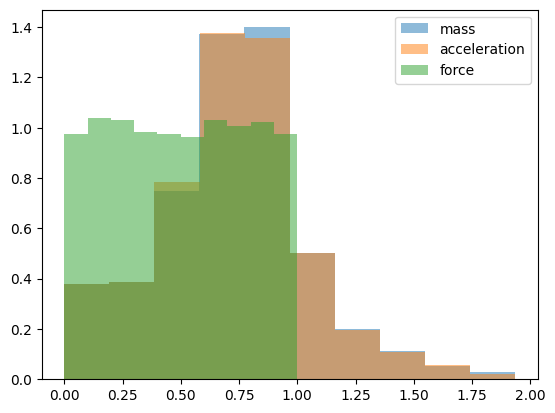

In [7]:
plot_data_distribution(*generate_data()[:2])

## Experiments

### Single linear projection

  0%|          | 0/4000 [00:00<?, ?it/s]

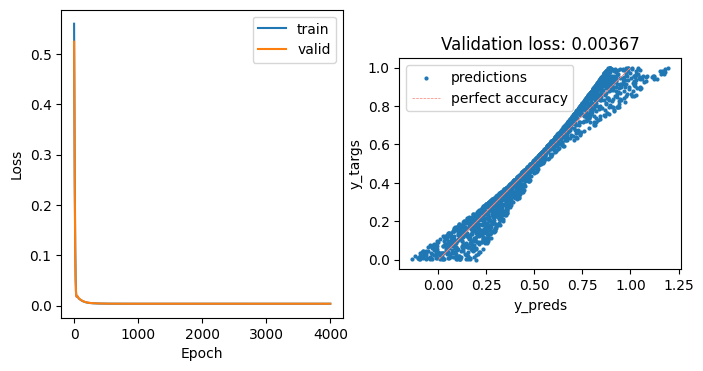

In [8]:
set_all_seeds(3768514969)
data = generate_data()
model = nn.Linear(2, 1)
model, df = train(model, data)
plot_model_performance_summary(model, df, *data[2:])

In [9]:
print_model_parameters(model)

weight 
 tensor([[0.6880, 0.6860]]) 

bias 
 tensor([-0.4906]) 



### 2D single hidden layer

This is the model that I will study in this section:

In [10]:
Net(use_act=True, dim=2)

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=2, out_features=2, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=2, out_features=1, bias=True)
    )
  )
)

It seems like we can describe the different trained "modes" that result from different random initialisations of this system by thinking about where a unit square input is transformed to by the hidden layer. This feels like one of the main factors in dictating the behaviour of the resulting algorithm.

We'll define the quadrants of the hidden space as below:

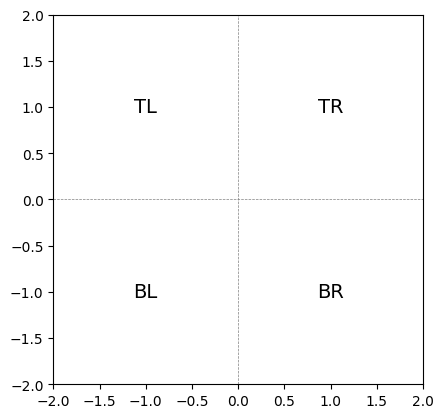

In [11]:
fig, ax = plt.subplots()

# set the x and y limits
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

ax.vlines(0, -2, 2, color="gray", ls="--", lw=0.5)
ax.hlines(0, -2, 2, color="gray", ls="--", lw=0.5)

# add the text in the center of each quadrant
ax.text(-1, 1, "TL", ha="center", va="center", fontsize=14)
ax.text(1, 1, "TR", ha="center", va="center", fontsize=14)
ax.text(-1, -1, "BL", ha="center", va="center", fontsize=14)
ax.text(1, -1, "BR", ha="center", va="center", fontsize=14)
ax.set_aspect("equal")

To generate the different locations of the transformed unit square input:

In [12]:
from itertools import combinations
from pprint import pprint

# define the elements to permute
elements = ("TR", "TL", "BL", "BR")

# find all permutations of any length
all_combinations = []
for i in range(1, len(elements) + 1):
    all_combinations += list(combinations(elements, i))

for i, combination in enumerate(all_combinations):
    print(f"{i+1}: {combination}")

1: ('TR',)
2: ('TL',)
3: ('BL',)
4: ('BR',)
5: ('TR', 'TL')
6: ('TR', 'BL')
7: ('TR', 'BR')
8: ('TL', 'BL')
9: ('TL', 'BR')
10: ('BL', 'BR')
11: ('TR', 'TL', 'BL')
12: ('TR', 'TL', 'BR')
13: ('TR', 'BL', 'BR')
14: ('TL', 'BL', 'BR')
15: ('TR', 'TL', 'BL', 'BR')


I'll label each with $C_n$ e.g. $C_{10}$ means the transformed unit square sits across the BL (bottom left) and BR (bottom right) quadrants.

I'm not sure if these combinations have much significance in themselves yet 🤔 but they've been a helpful way of breaking down the different behaviours/modes in a systematic way.

#### C3


This is the poorest performing mode as it results in translating an input unit square into the BL quadrant ($C_3$) meaning all values are zeroed by the ReLU. 

I believe this might occur due to a "bad" initialisation meaning values are transformed in this way early on in training, stopping gradients from propagating through the network to improve towards lower bias solutions.

In [13]:
set_all_seeds(3768514969)
data = generate_data()
model = Net(use_act=True, dim=2)
model, df = train(model, data)

  0%|          | 0/4000 [00:00<?, ?it/s]

In [14]:
print_model_parameters(model)

layers.0.linear.weight 
 tensor([[-0.1723,  0.2376],
        [-0.5974,  0.1212]]) 

layers.0.linear.bias 
 tensor([-0.3823, -0.4117]) 

layers.1.linear.weight 
 tensor([[-0.4247,  0.1906]]) 

layers.1.linear.bias 
 tensor([0.5019]) 



The plots below are simply:
- LEFT: the training and validation set losses throughout the training process (to make sure that we have converged)
- RIGHT: the target vs predicted y values.

We can see that the network is predicting a single (mean) value for all input values.

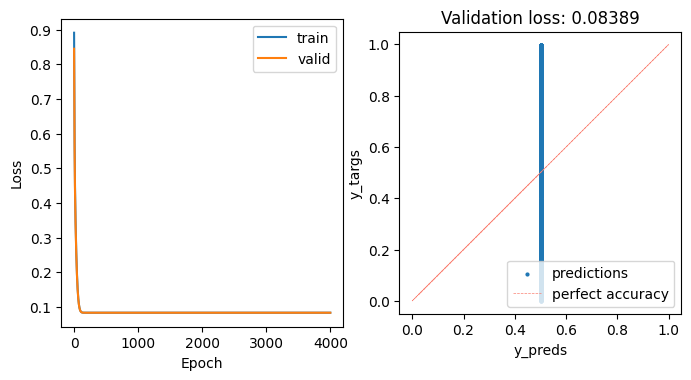

In [15]:
plot_model_performance_summary(model, df, *data[2:])

This plot below shows how an input unit square is transformed by the network after various operations. The 2D layers are easy to represent here and the 1D layers (i.e. from the output of the final linear weight multiplication onwards) are represented along the x-axis (component 1) - this was chosen arbitrarily but has proven useful in understanding the network dynamics.

**The grid of input points in the input unit square have been coloured according to their product (i.e. associated y-value)** in order to better see how the network works (or in this case doesn't work) to transform and cluster values of similiar magnitude (colour) together at each successive stage. 

We can see in this case how the unit square has been transformed to sit solely in the BL quadrant (at `layers.0.linear.bias`) meaning it is negative for all input values across both neurons and therefore all of its information is lost once passed through the activation function.

This means the only thing the network can now do it to transform these values to equal the mean of the targets (hence why it adds a 0.5 bias at the end).

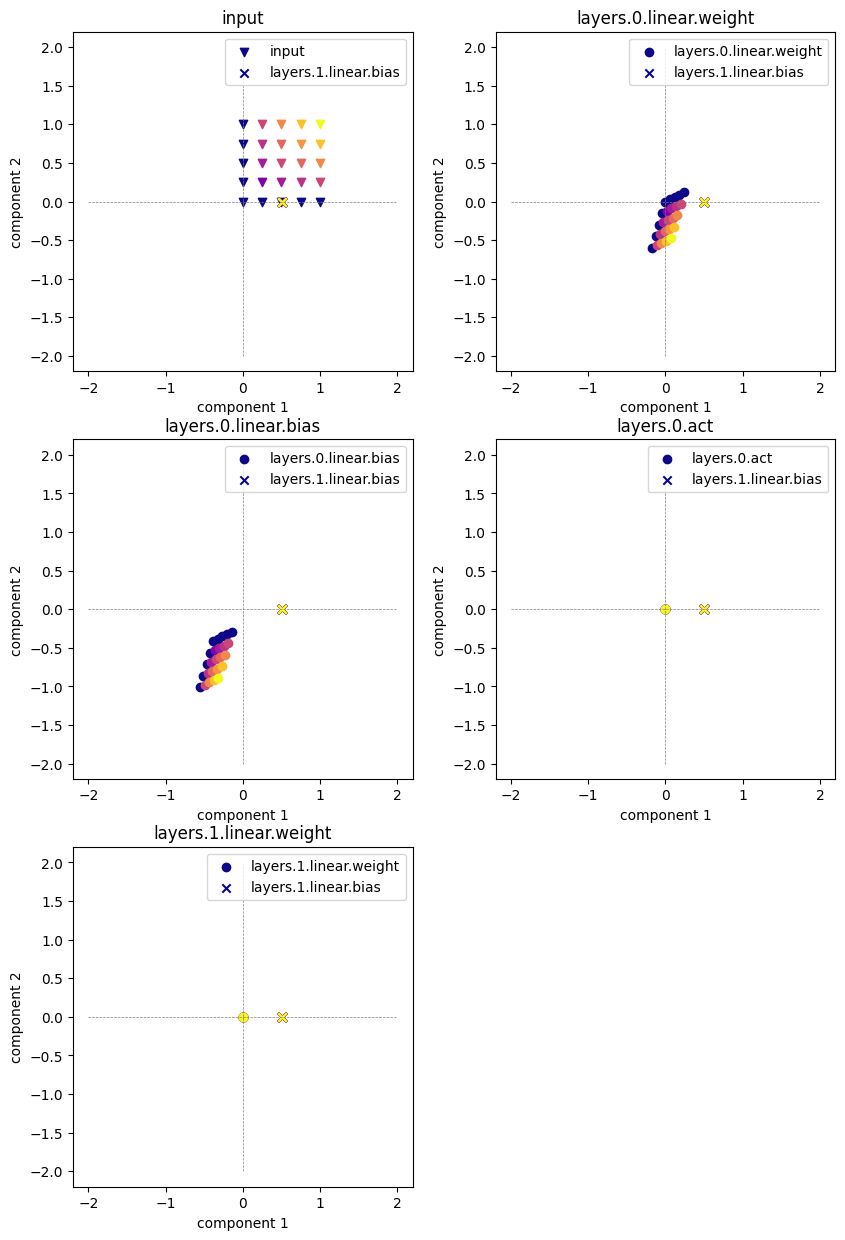

In [16]:
plot_subsets(model)

The plot below becomes more useful when considering networks with higher dimensional hidden layers but I'll include it throughout all just for comparison.

It is essentially the output of each neuron in the hidden layer at `layers.1.linear.weight` (represented with the colorbar scale) for a unit square input (on the $x_1$ and $x_2$ axes) and gives us a sense of how each neuron contributes to the final result (importantly **pre**-bias, whose value I have included in the title).

In this case, the neurons aren't active at all due to the aformentioned reasons so this isn't a very informative plot. It's essentially telling us that no input information propagates through this network. We shall see this plot's use a little later though. 

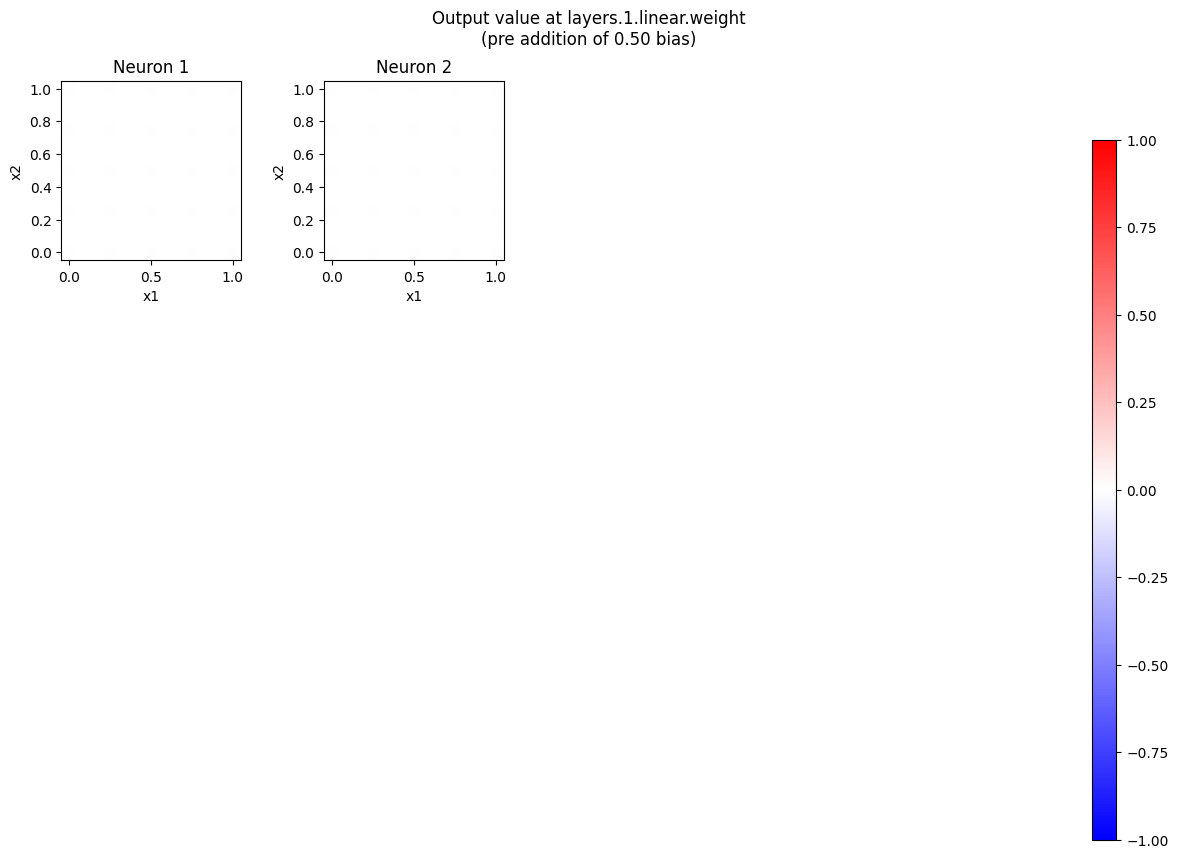

In [17]:
plot_neuron_contributions(model)

It's useful to intuitively think of this plot as if we're summing all of the above neuron maps together (followed by the addition of the bias) to produce the final ideal output which I've plotted below. We'll see later in other networks, how exactly the different neurons "collaborate" to refine the final result by operating on different parts of the input space. 

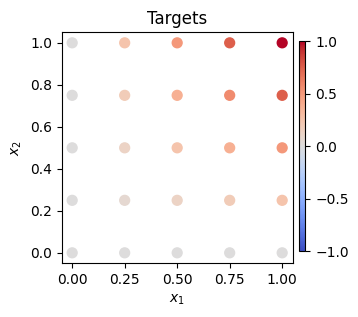

In [18]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=100)  # Increase the width to make space for the colorbar

pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, 5), np.linspace(0, 1, 5))).T)

col = pairs[:, 0] * pairs[:, 1]
activated_mask = torch.ones(col.shape, dtype=bool)
sc = ax.scatter(
    pairs[activated_mask, 0],
    pairs[activated_mask, 1],
    c=col[activated_mask],
    cmap="coolwarm",
    s=50,
    norm=plt.Normalize(vmin=-1, vmax=1),
)

ax.set_title(f"Targets")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_aspect("equal")
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# Position the colorbar on the right of the last subplot
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
_ = fig.colorbar(sc, cax=cbar_ax, use_gridspec=True)

#### C2

Due to the symmetry of this setup $C_2$ modes will be functionally equivalent to $C_4$ modes just orthognally rotated in the hidden space.

  0%|          | 0/4000 [00:00<?, ?it/s]

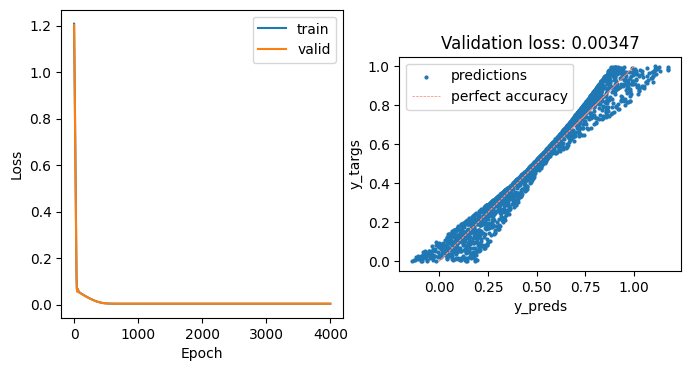

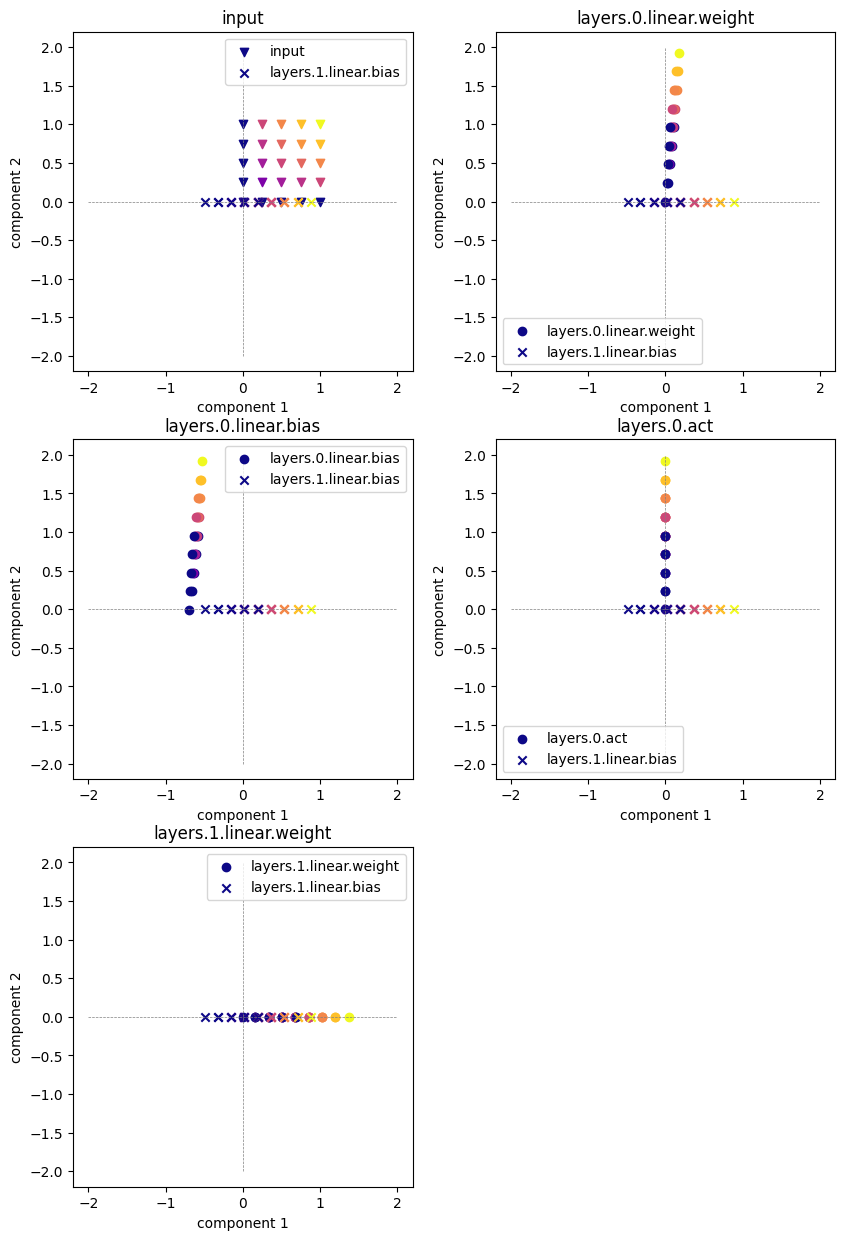

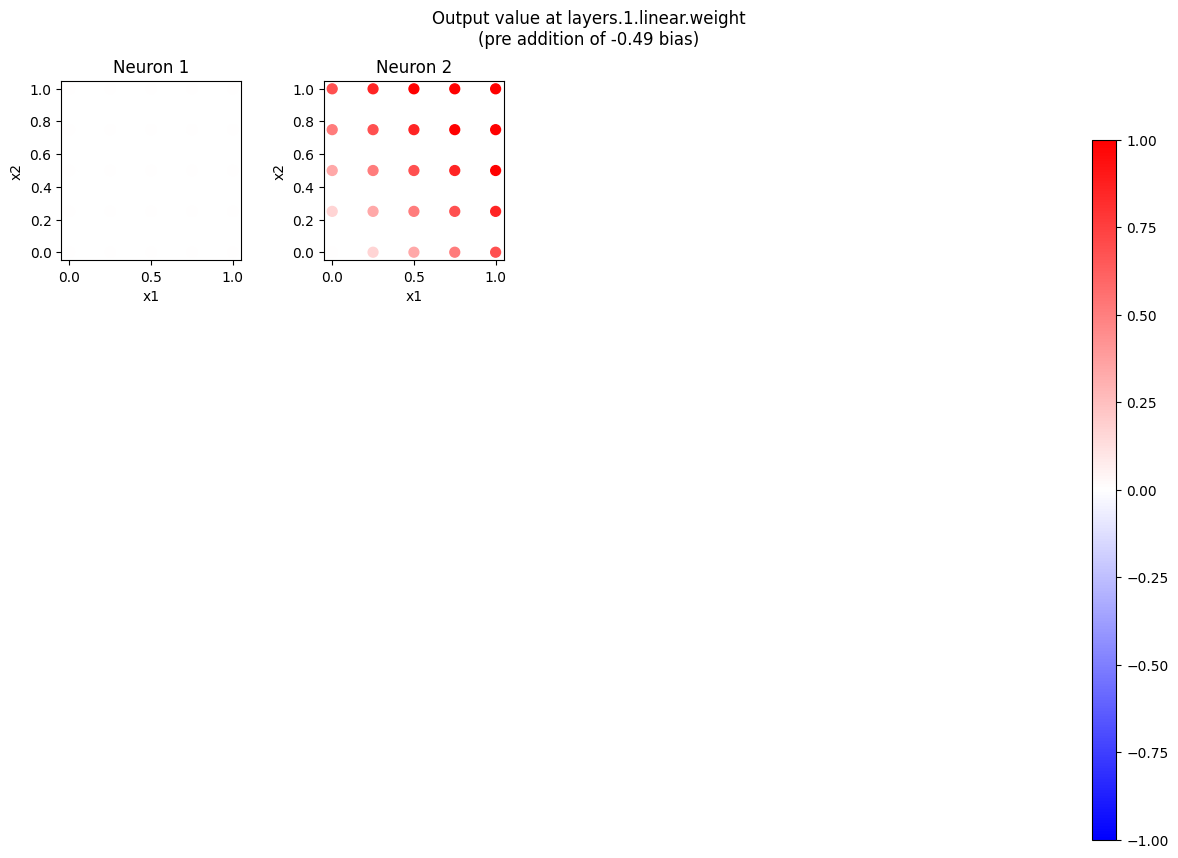

In [19]:
set_all_seeds(344339333)
data = generate_data()
model = Net(use_act=True, dim=2)
model, df = train(model, data)
plot_model_performance_summary(model, df, *data[2:])
plot_subsets(model)
plot_neuron_contributions(model)

In this mode we can see in the first set of graphs that the prediction distribution is better than simply a constant but it is still quite inaccurate.

In these modes I've typically observed that the network aims to first align the diagonals of the input square since they share a roughly similar value. It then uses the ReLU (as opposed to `layers.1.linear`) as some kind of projection followed by simply projections to 1D with a bias to refine at the end.

We can see from the last plot that only one neuron in the hidden layer is in use across the whole input space. Which begs the question... can we make use of that other neuron?

I thought a little more about this aligning of diagonals and realised that the optimal transformation of the unit square would be to "straighten-out" the iso-curves (in the plot below) in the hidden space before a projection.

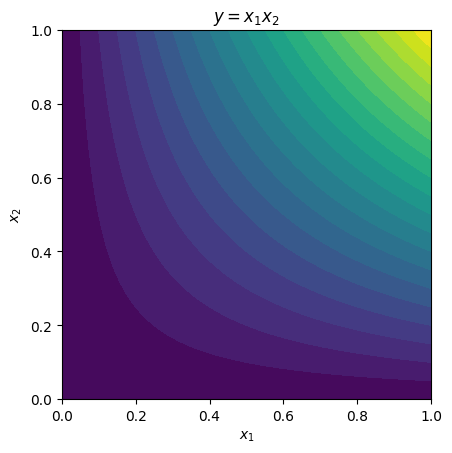

In [20]:
N = 1000
pairs = np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))
B = pairs[0]
C = pairs[1]
D = pairs[0] * pairs[1]

fig, ax = plt.subplots()
ax.contourf(B, C, D, 20, cmap="viridis")
ax.set_aspect("equal")
ax.set_title("$y=x_1x_2$")
_ = ax.set(xlabel="$x_1$", ylabel="$x_2$")

Unfortunately, this isn't possible in a single MLP layer. The intuition I've built is that with a higher dimensional hidden layer, the MLP learns to approximate this straightening out of the isocurves in a piece-wise fashion. More on that later. 

#### C15

This one is the most optimal model I have found.

  0%|          | 0/4000 [00:00<?, ?it/s]

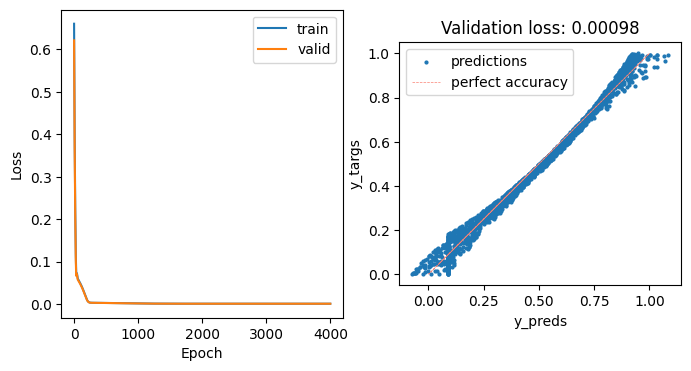

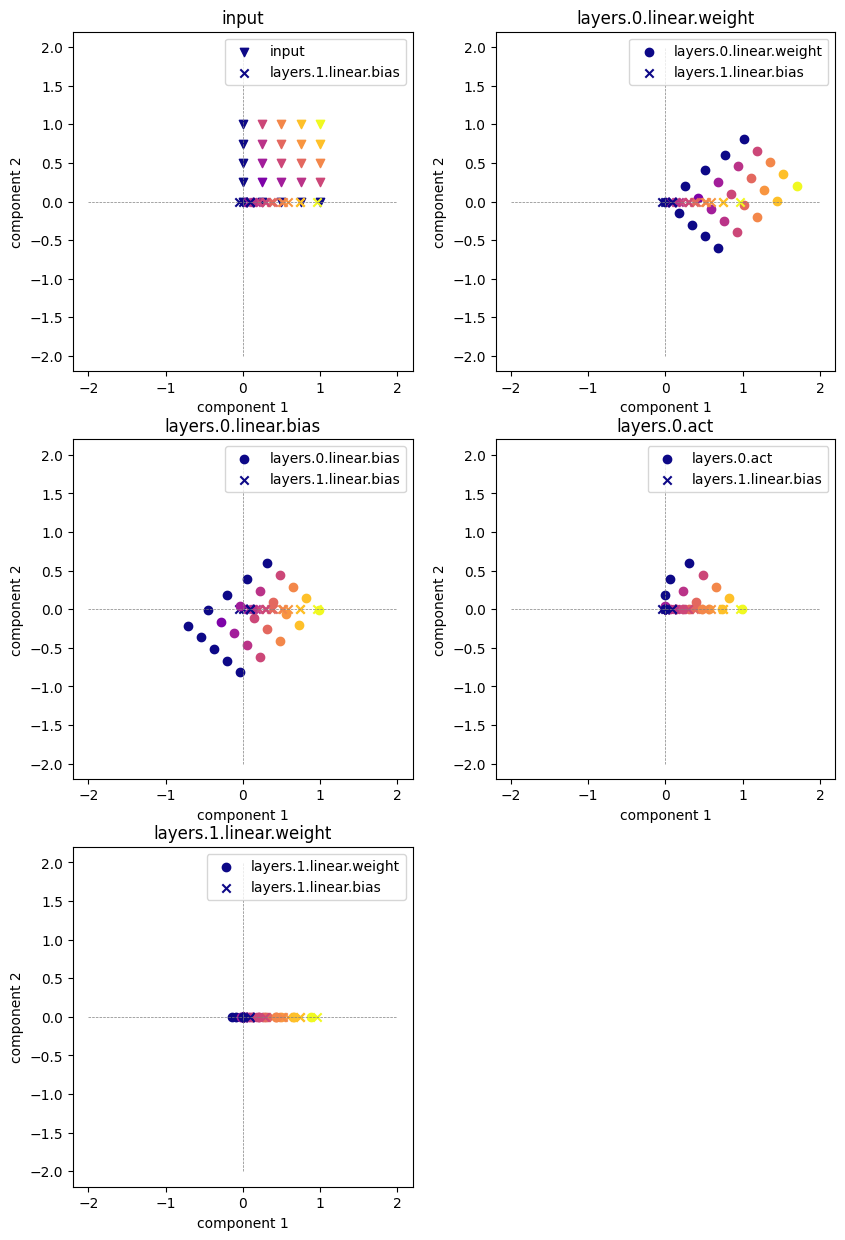

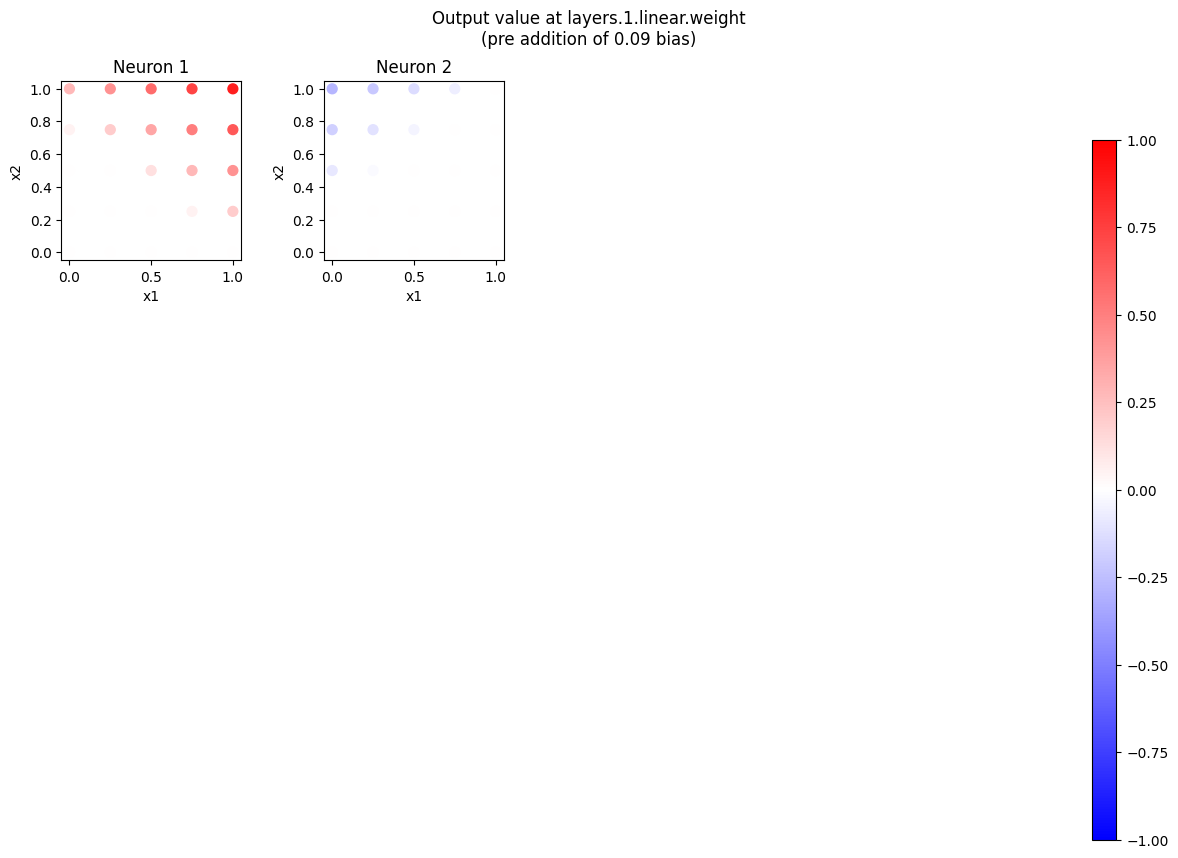

In [21]:
set_all_seeds(2432571267)
data = generate_data()
model = Net(use_act=True, dim=2)
model, df = train(model, data)
plot_model_performance_summary(model, df, *data[2:])
plot_subsets(model)
plot_neuron_contributions(model)

This mode makes use of $C_{15}$ with the unit square transformed to be straddled across all four quadrants.

If we think more carefully about the `layers.0.linear.bias` plot, then we can see that the square has been transformed such that:
- the BL quadrant is "mopping up" some of the lowest values (the darker colours) so they all go to zero
- the TL and BR quadrants are playing similar roles but we retain some information that we can use after the activation has been applied to separate the low from the high values further
- the TR quadrant isn't affected by the activation but the network can now use the fact that the low values which remain in the TR have a greater component 2 magnitude, allowing the final linear layer to separate them better

Looking at it from a different perspective in the bottom graph (now also taking into account the linear layer), we can see that neuron 1 (i.e. component 1) is producing the main bulk of the desired distribution and neuron 1 is correcting it in the region of small $x_1$ large $x_2$ where it overshoots a little.

All quite anthropomorphic, but I've found it helps me understand at a base level what's going on.

#### C5

This was a potentially interesting mix between $C_2$ and $C_{15}$ in terms of behaviour.

  0%|          | 0/4000 [00:00<?, ?it/s]

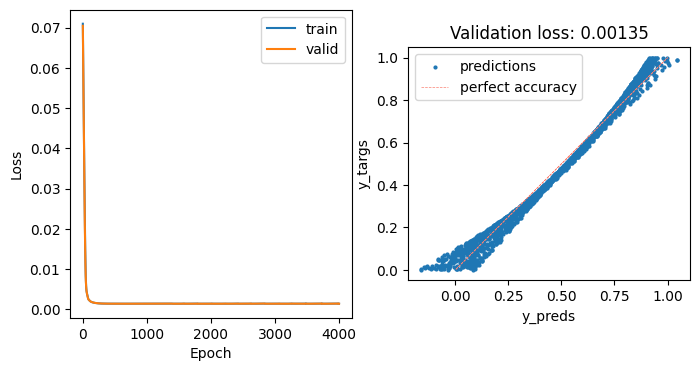

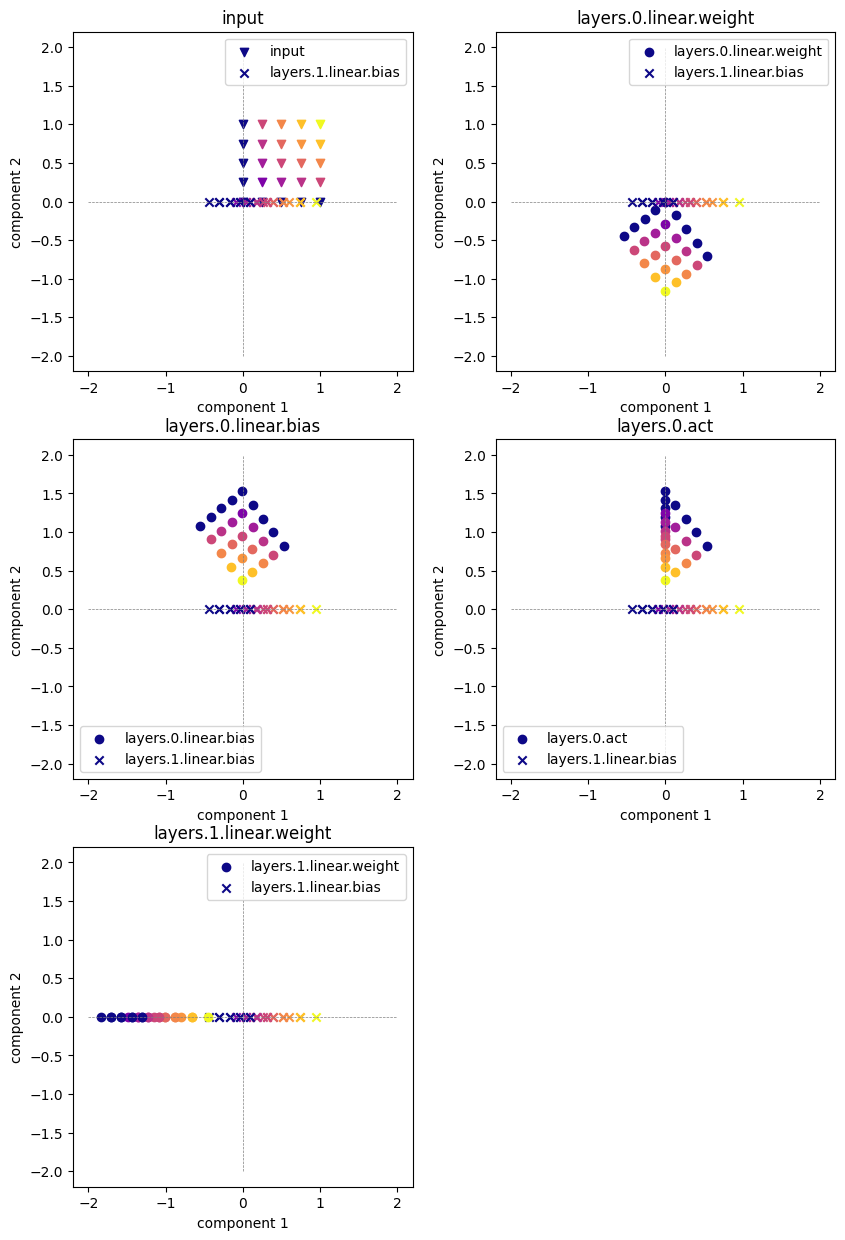

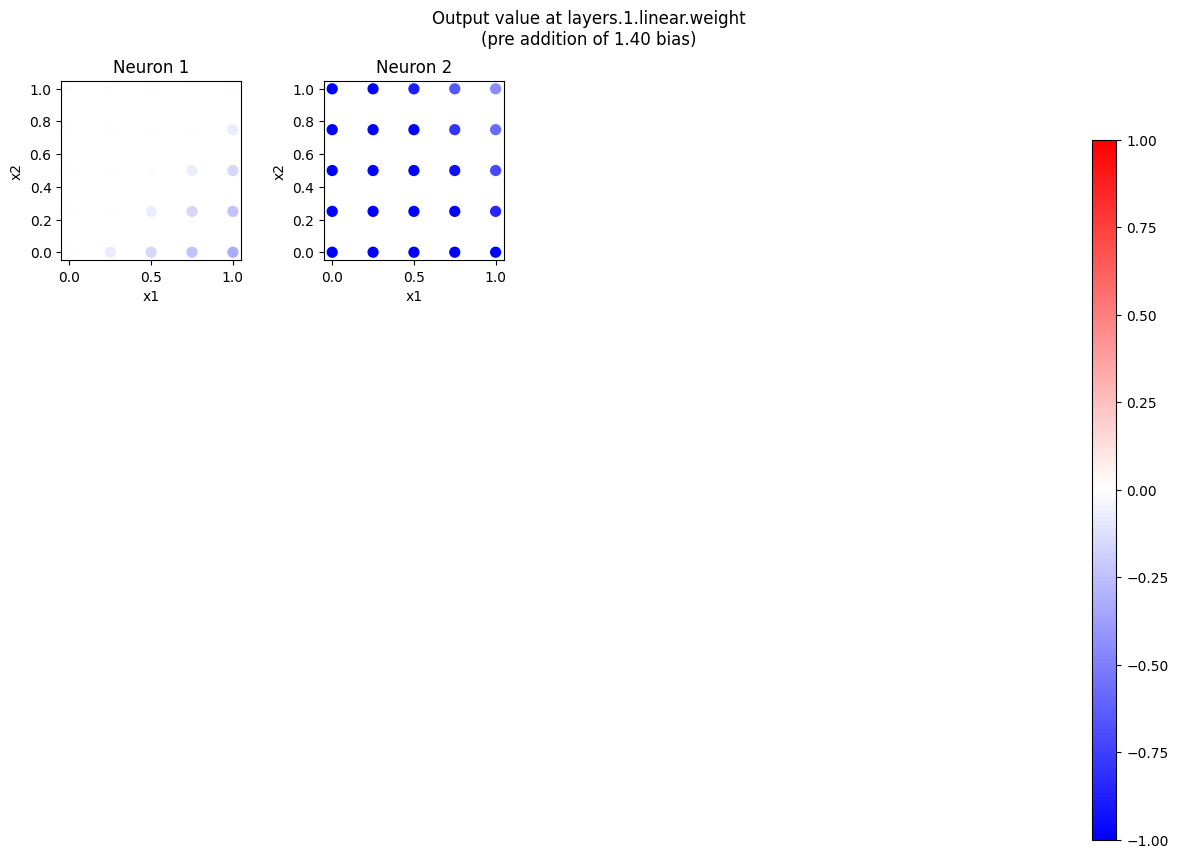

In [22]:
set_all_seeds(2813536937)
data = generate_data()
model = Net(use_act=True, dim=2)
model, df = train(model, data)
plot_model_performance_summary(model, df, *data[2:])
plot_subsets(model)
plot_neuron_contributions(model)

Instead of the projection to separate components from the ReLU (as in $C_{15}$), we project to only one of them. It also doesn't have (the more information lossy) ReLU "projection" of the BL quadrant to zero. 

The network can still use the extent in component 1 to help separate the values further in the final linear layer.

Note on the bottom neuron plot that both neurons are in use. The values are negative because the network flips them afterwards with the positive bias.

### Some general thoughts on these 2D single hidden layer experiments

I haven't described every single resulting trained mode that corresponds to each of the $C_{1-N}$ quadrant combinations that I laid out earlier because many feel equivalent (due to symmetry in the problem) and many I found perhaps less interesting.

A general intuition I get from looking at these results is that (at least in this system), the more optimal (lower loss) solutions make "more use" of the tools they have available.

For example, to pick the two extremes:
- $C_{3}$: uses only the final bias (a single parameter) to predict the result and none of the other tools at its disposal (not even the inputs it seems)
- $C_{15}$: by transforming the input square to sit across all four quadrants, it is making use of all of the four different paths it has available, each path processing the values differently. This in turn means it makes use of all the downstream parameters also.

We're essentially comparing essentially a 1-parameter to a 9-parameter model - and this wasn't obvious until breaking down exactly how each was operating. I wonder how much this idea applies to larger models? With more parameters, I'd imagine that there is more chance for parameter waste (/large sets of dead neurons) like this to appear without really noticing so much difference in the resulting loss.

### 16D single hidden layer

This is an attempt to understand if/how these findings generalise to a higher dimensional hidden layer. 

The difficulties that exist here are mainly in representing 16 dimensions in an understandable way.

I tried looking at the transformations of the unit input square between 2 dimensions at a time, as well as toying with 3D plots but they weren't so informative. Eventually, the neuron-wise heatmaps were the most useful.

  0%|          | 0/4000 [00:00<?, ?it/s]

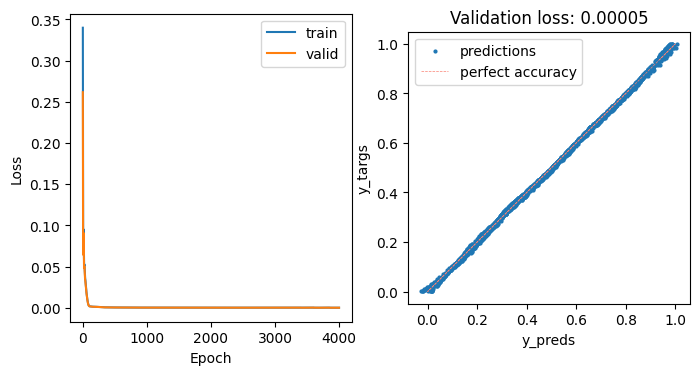

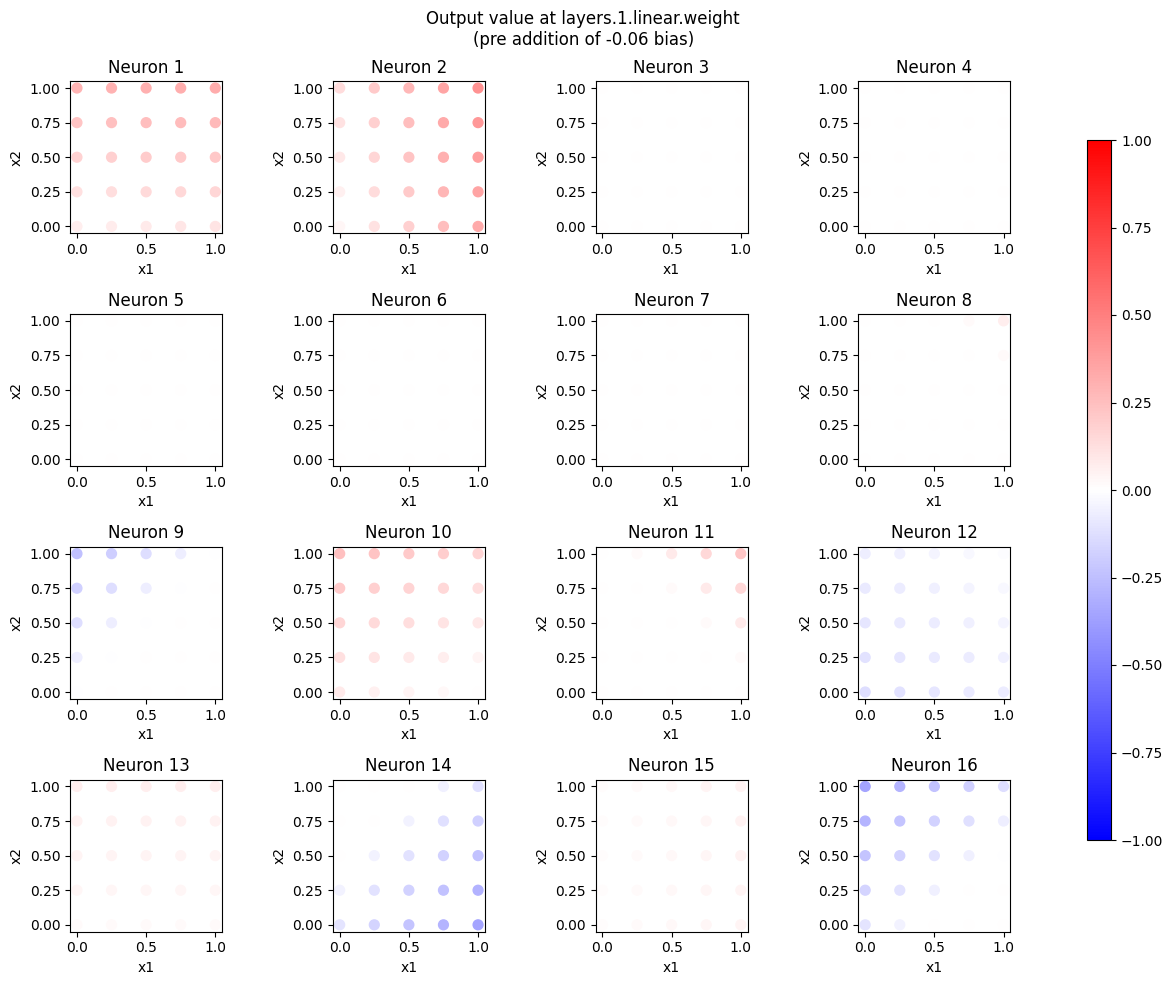

In [23]:
set_all_seeds(3787384592)
data = generate_data()
model = Net(use_act=True, dim=16)
model, df = train(model, data)
plot_model_performance_summary(model, df, *data[2:])
plot_neuron_contributions(model)

Some points to note:
- The performance is (understandably) much better than the 2D case - the network has many more parameters/dimensions to play with
- In a similar fashion to the (more optimal examples of the) 2D case, different neurons are focusing on different regions of the input space to correct/refine biases introduced by others.
- When I _did_ look at the 2D transform plots between various different dimensions, I could discern similar behaviour in terms of transforming the unit input into different quadrants followed by various ReLU projections and/or linear projections. The picture is obviously much more complicated now because rather than a nice and neat 15 different combinations of quadrants, we have $2^{2^{N}}-1$ (subtracting 1 for the empty set) combinations of "orthants" for an N-dimensional hidden layer. I tried to calculate this number for $N=16$ but python refused lol. We aren't really going to have much luck breaking down the "modes" of this network as a result but it would be interesting to think about other things we could say about these solutions e.g. are there energy levels with degeneracy etc.?
- It seems to me that the bottom plot is a nice way to view the problem from the piecewise perspective of MLPs (that has had a lot of attention in the literature since Cybenko etc.) in that each neuron seems to be specialised towards different areas of the input and output space.
- Around half of the neurons are seemingly redundant. This we see in practical examples of neural networks too. I thought this was worth exploring further, especially when in comes down to multi-task networks.

#### Verify neuron redundancy

Just going to carry out a basic pruning to verify that there are essentially redundant neurons.

In [53]:
ε = 1e-4
pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, 5), np.linspace(0, 1, 5))).T)
outputs = capture_intermediate_outputs(model, torch.as_tensor(pairs).float())
neuron_contributions = (outputs["layers.0.act"] * model.state_dict()["layers.1.linear.weight"]).mean(0)
keep_mask = neuron_contributions.abs() > ε
with torch.no_grad():
    model.layers[0].linear.weight[~keep_mask] = 0
    model.layers[0].linear.bias[~keep_mask] = 0
    model.layers[1].linear.weight[:, ~keep_mask] = 0
print(f"Number of neurons pruned: {(~keep_mask.numpy()).sum()}/{len(keep_mask)}")

Number of neurons pruned: 5/16


In [49]:
print_model_parameters(model)

layers.0.linear.weight 
 tensor([[ 0.1807,  1.1115],
        [ 0.8001,  0.2657],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.3789,  0.3833],
        [-0.6113,  0.6189],
        [-0.3490,  0.7788],
        [ 0.6002,  0.6043],
        [-0.3049, -0.3068],
        [-0.0043,  0.1974],
        [ 0.6603, -0.6218],
        [ 0.3540,  0.0422],
        [-0.8520,  0.9344]]) 

layers.0.linear.bias 
 tensor([ 0.3353,  0.1049,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.6193,
         0.0091,  0.3713, -0.7140,  0.6699,  0.1077,  0.2787,  0.0775,  0.4038]) 

layers.1.linear.weight 
 tensor([[ 0.2001,  0.3646,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.4619,
         -0.3949,  0.2145,  0.4486, -0.1936,  0.2099, -0.3821,  0.1041, -0.2628]]) 

layers.1.linear.bias 
 tensor([-0.0572]) 



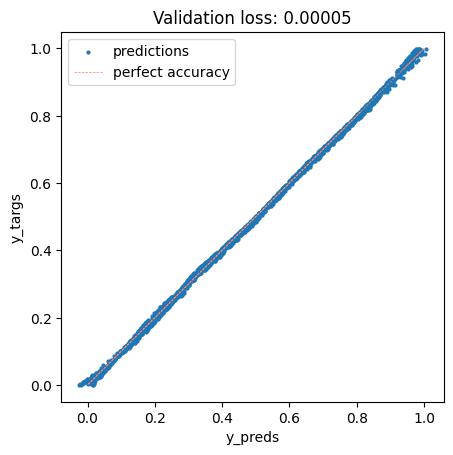

In [56]:
plot_results(
    *get_preds(model, *data[2:]), title=f"Validation loss: {get_valid_loss(model, nn.MSELoss(), *data[2:]):.5f}"
)

This has barely really made a dent on the loss/performance so I would say we have verified that these neurons are redundant (if there was any doubt).

### 2x2D hidden layers

Having explored how the network distributed this multiplication task amongst multiple hidden dimensions, I wanted to get a sense of how it would distribute a task between multiple layers.

Reducing the dimensionality to 2D again to keep things more easily interpretable.

In [87]:
class DeeperNet(Net):
    def __init__(self, use_act=True, dim=2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(2, dim, use_act=use_act),
            LinearLayer(dim, dim, use_act=use_act),  # have added this little guy
            LinearLayer(dim, 1, use_act=False),
        )


def get_deep_point_selector_sets():
    subsets = []
    for i in range(8):
        subset = {
            "input": False,
            "layers.0.linear.weight": False,
            "layers.0.linear.bias": False,
            "layers.0.act": False,
            "layers.1.linear.weight": False,
            "layers.1.linear.bias": False,
            "layers.1.act": False,
            "layers.2.linear.weight": False,
            "layers.2.linear.bias": True,
        }
        subset[list(subset.keys())[i]] = True
        subsets.append(subset)
    subsets[0]["input"] = True
    return subsets

  0%|          | 0/4000 [00:00<?, ?it/s]

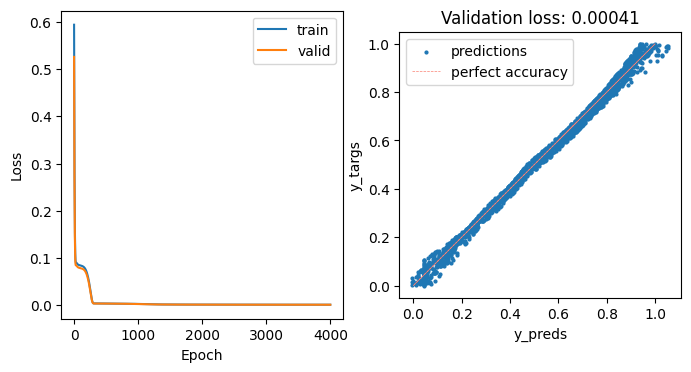

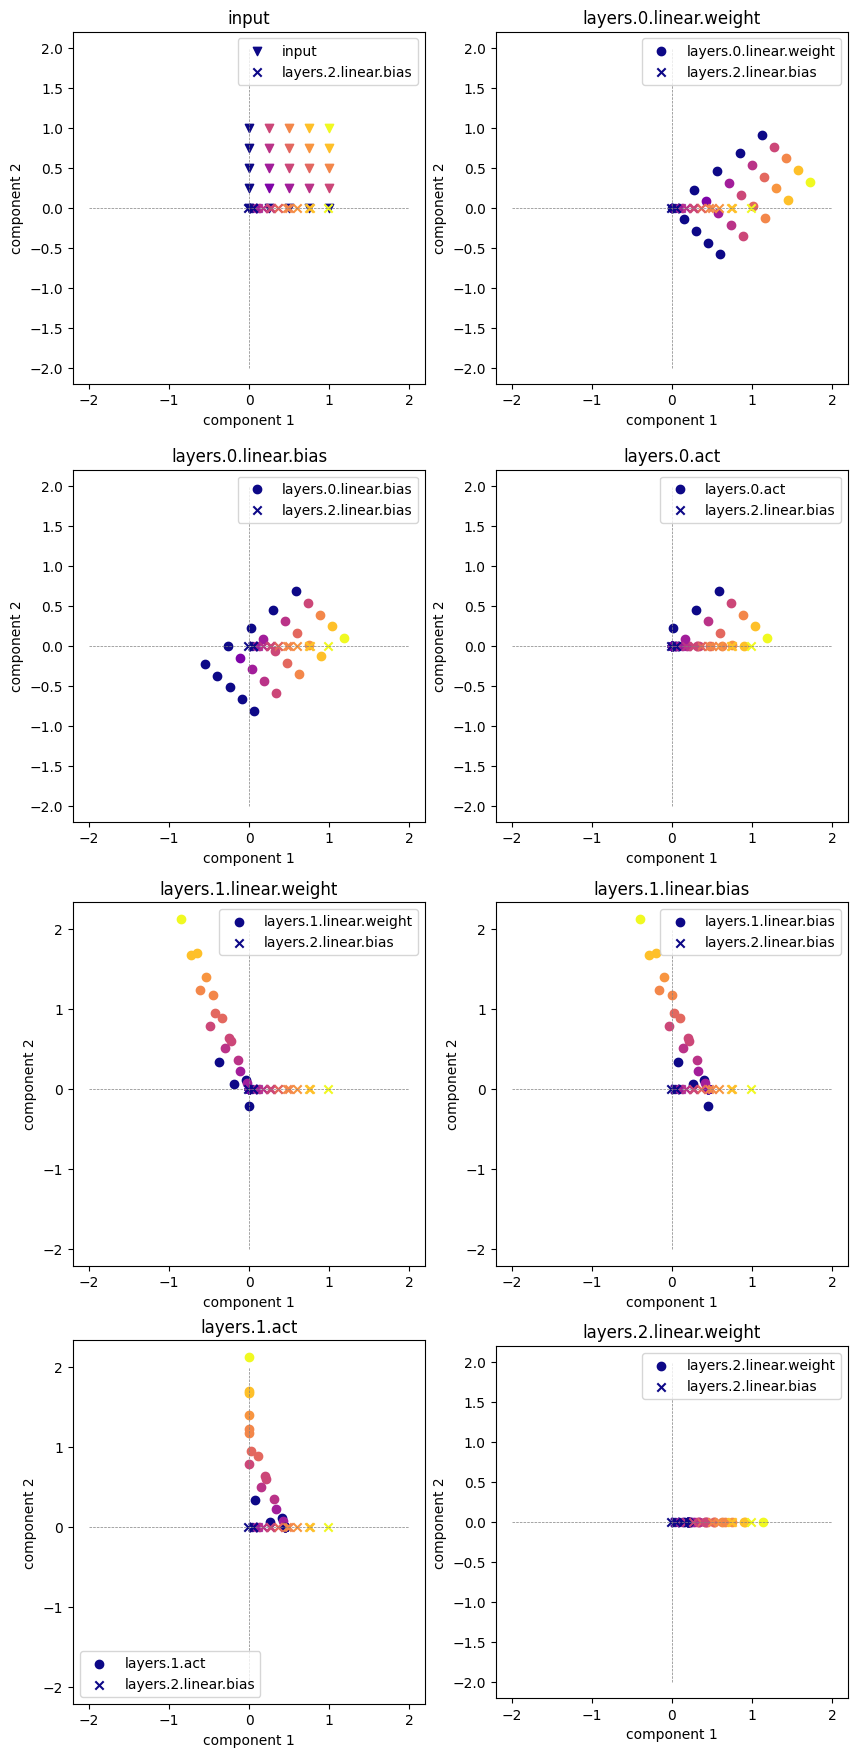

In [121]:
seed = generate_seed()
set_all_seeds(1486599008)
data = generate_data()
model = DeeperNet(use_act=True, dim=2)
model, df = train(model, data)
plot_model_performance_summary(model, df, *data[2:])
plot_subsets(model, subsets=get_deep_point_selector_sets())

Some points here:
- It was harder to get good results (my training loop is simple and deeper networks are well known to be harder to optimise)
- The first hidden layer carries out a computation much like the single-layer $C_{15}$ example I presented earlier except that it can use the next layer to further separate and project the values to produce better results.

I don't find this multi-layer network particularly more interesting than the single layer case. Across the examples I trained, later layers seem to simply build and refine on the representations that I have already observed. I'm not sure if there's much more to look at for the moment here. 